![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

--------------------------------------------

Analisis de variables

Estadisticas descriptivas de los datos:
             season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886

Text(0, 0.5, 'total')

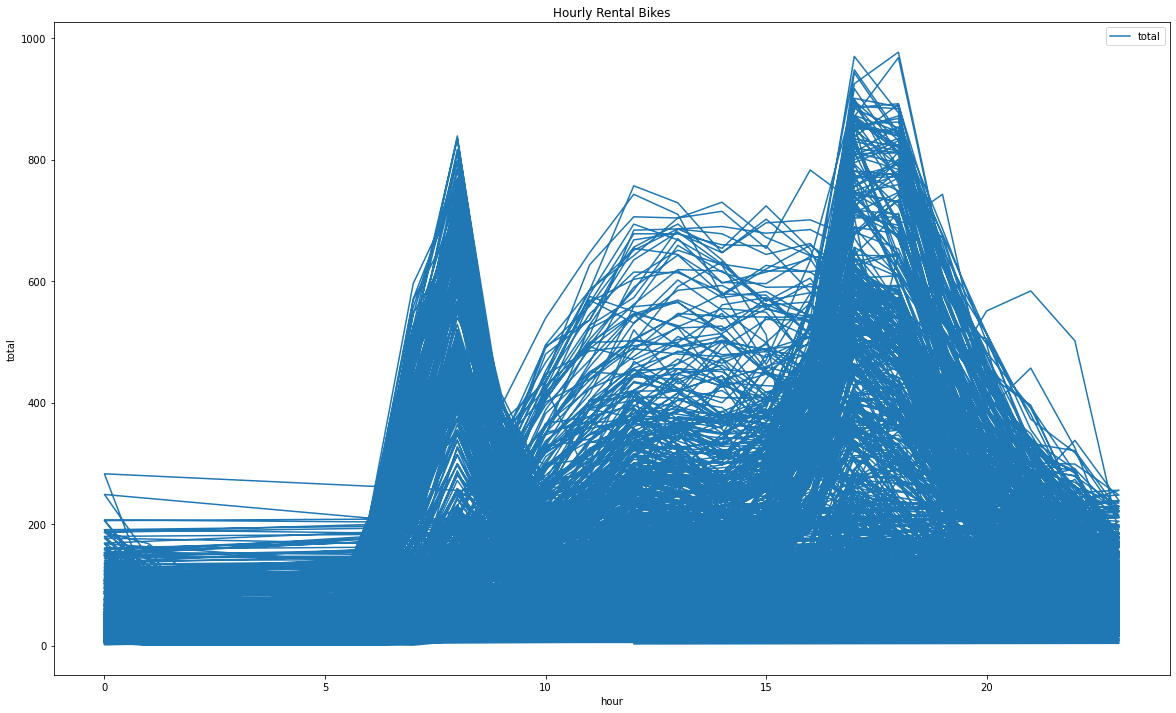

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

#Librerias gráficas
import matplotlib.pyplot as plt
import matplotlib

print('--------------------------------------------')
print('\r\nAnalisis de variables\r\n')
print('Estadisticas descriptivas de los datos:')
estadisticas=bikes.describe(include = 'all')
print(estadisticas)

bikes.plot(x='hour', y='total', figsize=(20,12), title = 'Hourly Rental Bikes')
plt.ylabel('total')


In [7]:
print("El csv contiene 10886 muestras y 12 variables, incluída la variable hour.")
print("Gracias al análisis de los datos podemos inferir respecto a las variables hour y workingday que en promedio es mucho más frecuente el uso de bicicletas compartidas en los periodos de 7 a 9 am y de 3 a 7 pm y, además, si el día no es fin de semana o festivo es ligeramente más usual que los biciusuarios usen el producto.") 

El csv contiene 10886 muestras y 12 variables, incluída la variable hour.
Gracias al análisis de los datos podemos inferir respecto a las variables hour y workingday que en promedio es mucho más frecuente el uso de bicicletas compartidas en los periodos de 7 a 9 am y de 3 a 7 pm y, además, si el día no es fin de semana o festivo es ligeramente más usual que los biciusuarios usen el producto.


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

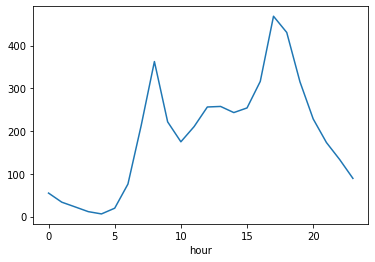

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

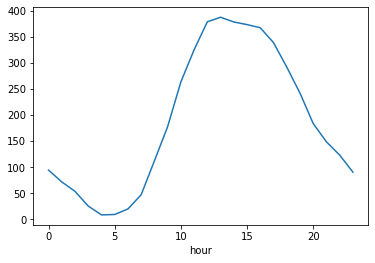

In [9]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
(bikes.loc[bikes['workingday']==0]).groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

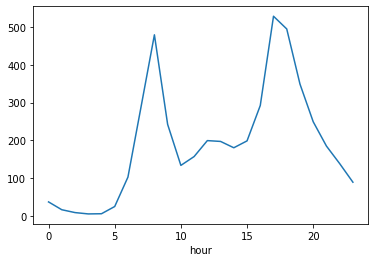

In [10]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
(bikes.loc[bikes['workingday']==1]).groupby('hour').total.mean().plot()

In [11]:
print("Resulta interesante el contraste entre los días festivos y no festivos. Por un lado, cuando es fin de semana o festivo (0) hay una mayor afluencia de alquileres de bicicletas entre las 10 am y las 3 pm; caso contrario ocurre en los días laborales (1), pues es la franja en la que el alquiler disminuye notablemente, sus topes son entre las 8 y 9 am y después de las 4 pm.")

Resulta interesante el contraste entre los días festivos y no festivos. Por un lado, cuando es fin de semana o festivo (0) hay una mayor afluencia de alquileres de bicicletas entre las 10 am y las 3 pm; caso contrario ocurre en los días laborales (1), pues es la franja en la que el alquiler disminuye notablemente, sus topes son entre las 8 y 9 am y después de las 4 pm.


### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [12]:
# Celda 3
from sklearn import linear_model
from sklearn.metrics import r2_score
Y = bikes.total
X = bikes.drop(['season', 'holiday', 'weather','temp', 'atemp','humidity','windspeed','casual','registered', 'total'],axis=1)
model=linear_model.LinearRegression()
model.fit(X,Y)
Y_pred= model.predict(X)
print('Coeficientes', model.coef_)
print('Intercepto', model.intercept_)
print('Medida de bondad de ajuste R2: %.2f' % r2_score(Y,Y_pred))

Coeficientes [ 4.07248627 10.49206282]
Intercepto 67.70595026191619
Medida de bondad de ajuste R2: 0.16


In [13]:
print(' La limitación del modelo se da en que el 16% de la variabilidad observada en Y es explicada por las variables incluidas en el modelo, esto quiere decir que los datos están lejos de la línea de tendencia, por lo que los mismos no poseen una relación lineal.')

 La limitación del modelo se da en que el 16% de la variabilidad observada en Y es explicada por las variables incluidas en el modelo, esto quiere decir que los datos están lejos de la línea de tendencia, por lo que los mismos no poseen una relación lineal.


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [14]:
from sklearn.model_selection import train_test_split
XTrain, XTest, yTrain, yTest = train_test_split(X, Y, test_size=0.33, random_state=0)

class DecisionTreeRegress:
  
  def fit(self, x, y, min_leaf = 7):
    self.dtree = Node(x, y, np.array(np.arange(len(y))), min_leaf)
    return self
  def predict(self, x):
    return self.dtree.predict(x.values)

class Node:

    def __init__(self, x, y, idxs, min_leaf=7):
        self.x = x 
        self.y = y
        self.idxs = idxs 
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for c in range(self.col_count): self.find_better_split(c)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(self.x, self.y, self.idxs[lhs], self.min_leaf)
        self.rhs = Node(self.x, self.y, self.idxs[rhs], self.min_leaf)
        
    def find_better_split(self, var_idx):
      
        x = self.x.values[self.idxs, var_idx]

        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]
            if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: continue

            curr_score = self.find_score(lhs, rhs)
            if curr_score < self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]
                
    def find_score(self, lhs, rhs):
        y = self.y[self.idxs]
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        return lhs_std * lhs.sum() + rhs_std * rhs.sum()
                
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]
                
    @property
    def is_leaf(self): return self.score == float('inf')                

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)
    
regressor = DecisionTreeRegress().fit(XTrain, yTrain)
preds = regressor.predict(XTest)
MSE=np.average(np.square(preds-yTest))


In [15]:
print(regressor)
print(preds)
print('MSE:')
print(MSE)

[186.79326923 283.98564593 283.98564593 ... 200.54976303  87.27722772
 193.29292929]
MSE:
11416.523647035094


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

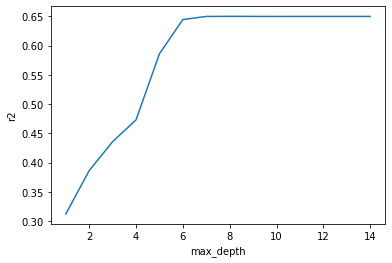

(0.6501337581022684, 8)
Mejor R2: 0.6504671083410165


In [60]:
# Celda 5

max_depth_range = range(1, 15)
accuracy_scores = []

for depth in max_depth_range:
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, XTrain, yTrain, cv=10, scoring='r2').mean())
    
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('r2')
plt.show()

# Mejor R2 
best_tree = sorted(zip(accuracy_scores, max_depth_range))[::-1][0][1]
print(sorted(zip(accuracy_scores, max_depth_range))[::-1][0])

clf = DecisionTreeRegressor(max_depth=best_tree, random_state=1)
clf.fit(XTrain, yTrain)
yPred = clf.predict(XTest)
print("Mejor R2: " + str(r2_score(yTest, yPred)))

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [28]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [29]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [30]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

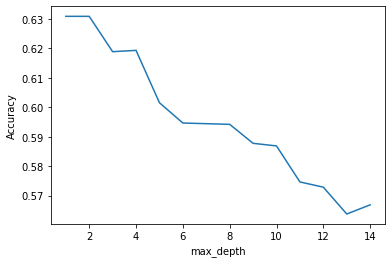

Árbol de decisión
Accuracy: 0.6453333333333333
F1: 0.6448598130841121
Regresión Logistica
Accuracy: 0.6146666666666667
F1: 0.6110363391655451


In [31]:
# Celda 6
from sklearn import metrics
max_depth_range = range(1, 15)
accuracy_scores  = []

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

best_num_tree = sorted(zip(accuracy_scores, max_depth_range))[::-1][0][1]

#Metrics
arbol = DecisionTreeClassifier(max_depth=best_num_tree, random_state=1)
arbol.fit(X_train, y_train)
yPred = arbol.predict(X_test)


print("Árbol de decisión")
print("Accuracy: " + str(metrics.accuracy_score(y_test, yPred)))
print("F1: " + str(metrics.f1_score(y_test, yPred)))

reg = LogisticRegression().fit(X_train, y_train)
yPred1 = reg.predict(X_test)

print("Regresión Logistica")
print("Accuracy: " + str(metrics.accuracy_score(y_test, yPred1)))
print("F1: " + str(metrics.f1_score(y_test, yPred1)))

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [55]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingRegressor

estimadores = 100

bagreg = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=None),
    n_estimators=300,
    learning_rate=1
)


bagreg1 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=300,
    learning_rate=1
)


bagreg2 = AdaBoostClassifier(
    LogisticRegression(),
    n_estimators=300,
    learning_rate=1
)

#max_depth = None
mdnone = BaggingClassifier(base_estimator = bagreg, n_estimators=estimadores, bootstrap =True, random_state=42, n_jobs=-1, oob_score=True)
#max_depth = 2
md2 = BaggingClassifier(base_estimator = bagreg1, n_estimators=estimadores, bootstrap =True, random_state=42, n_jobs=-1, oob_score=True)
#Logistic
logistic = BaggingClassifier(base_estimator= bagreg2, n_estimators=estimadores, bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

print("Desempeño de votación mayoritaria")
mdnone.fit(X_train, y_train)
ypredmdnone = mdnone.predict(X_test)
print("---------------")
print("Max_depth = None")
print("Accuracy: " + str(metrics.accuracy_score(ypredmdnone, y_test)))
print("F1: " + str(metrics.f1_score(ypredmdnone, y_test)))

md2.fit(X_train, y_train)
ypredmd2 = md2.predict(X_test)
print("Max_depth = 2")
print("Accuracy: " + str(metrics.accuracy_score(ypredmd2, y_test)))
print("F1: " + str(metrics.f1_score(ypredmd2, y_test)))

logistic.fit(X_train, y_train)
ypredml = logistic.predict(X_test)
print("Logistic")
print("Accuracy: " + str(metrics.accuracy_score(ypredml, y_test)))
print("F1: " + str(metrics.f1_score(ypredml, y_test)))


Desempeño de votación mayoritaria
---------------
Max_depth = None
Accuracy: 0.6486666666666666
F1: 0.6535174227481921
Max_depth = 2
Accuracy: 0.6393333333333333
F1: 0.6452459016393443
Logistic
Accuracy: 0.616
F1: 0.6033057851239669


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [56]:
estimadores = 100

bagreg = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=None),
    n_estimators=300,
    learning_rate=1
)


bagreg1 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=300,
    learning_rate=1
)


bagreg2 = AdaBoostClassifier(
    LogisticRegression(),
    n_estimators=300,
    learning_rate=1
)


#max_depth = None
errors_none = np.zeros(mdnone.n_estimators)
y_pred_all_none = np.zeros((X_test.shape[0], mdnone.n_estimators))

#max_depth = 2
errors_2 = np.zeros(md2.n_estimators)
y_pred_all_2 = np.zeros((X_test.shape[0], md2.n_estimators))

#logistic
errors_logistic = np.zeros(logistic.n_estimators)
y_pred_all_logistic = np.zeros((X_test.shape[0], logistic.n_estimators))

for i in range(estimadores):
    
    #max_depth = None
    oob_sample = ~mdnone.estimators_samples_[i]
    y_pred_ = mdnone.estimators_[i].predict(X_train.values[oob_sample])
    errors_none[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_none[:, i] = mdnone.estimators_[i].predict(X_test)
    
    #max_depth = 2
    oob_sample = ~md2.estimators_samples_[i]
    y_pred_ = md2.estimators_[i].predict(X_train.values[oob_sample])
    errors_2[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_2[:, i] = md2.estimators_[i].predict(X_test)
    
    #logistic
    oob_sample = ~logistic.estimators_samples_[i]
    y_pred_ = logistic.estimators_[i].predict(X_train.values[oob_sample])
    errors_logistic[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_logistic[:, i] = logistic.estimators_[i].predict(X_test)

print("Desempeño de votación mayoritaria")
alpha = (1 - errors_none) / (1 - errors_none).sum()
ypredmdnone1 = (np.sum(y_pred_all_none * alpha, axis=1) >= 0.5).astype(np.int)
print("---------------")
print("Max_depth = None")
print("Accuracy: " + str(metrics.accuracy_score(ypredmdnone, y_test)))
print("F1: " + str(metrics.f1_score(ypredmdnone, y_test)))

alpha = (1 - errors_2) / (1 - errors_2).sum()
ypredmd21 = (np.sum(y_pred_all_2 * alpha, axis=1) >= 0.5).astype(np.int)
print("Max_depth = 2")
print("Accuracy: " + str(metrics.accuracy_score(ypredmd2, y_test)))
print("F1: " + str(metrics.f1_score(ypredmd2, y_test)))

alpha = (1 - errors_logistic) / (1 - errors_logistic).sum()
ypredml1 = (np.sum(y_pred_all_logistic * alpha, axis=1) >= 0.5).astype(np.int)
print("Logistic")
print("Accuracy: " + str(metrics.accuracy_score(ypredml, y_test)))
print("F1: " + str(metrics.f1_score(ypredml, y_test)))


Desempeño de votación mayoritaria
---------------
Max_depth = None
Accuracy: 0.6486666666666666
F1: 0.6535174227481921
Max_depth = 2
Accuracy: 0.6393333333333333
F1: 0.6452459016393443
Logistic
Accuracy: 0.616
F1: 0.6033057851239669


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

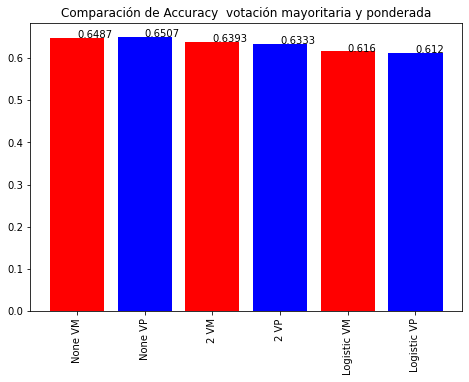

In [57]:
# Celda 9
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de Accuracy  votación mayoritaria y ponderada")
ejeX = ['None VM','None VP','2 VM','2 VP','Logistic VM','Logistic VP']
ejeY = [round(metrics.accuracy_score(ypredmdnone, y_test),4),
       round(metrics.accuracy_score(ypredmdnone1, y_test),4),
       round(metrics.accuracy_score(ypredmd2, y_test),4),
       round(metrics.accuracy_score(ypredmd21, y_test),4),
       round(metrics.accuracy_score(ypredml, y_test),4),
       round(metrics.accuracy_score(ypredml1, y_test),4)]

cc=['colors']*len(ejeX)
for n,val in enumerate(ejeX):
    if n%2:
        cc[n]='blue'
    else:
        cc[n]='red'

ax.bar(ejeX,ejeY, color = cc)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=90)
plt.show()

In [59]:
print("Los resultados de los clasificadores mayoritario y ponderado son muy similares. Sin embargo, la votación ponderada arroja una mejor métrica de accuracy.")

Los resultados de los clasificadores mayoritario y ponderado son muy similares. Sin embargo, la votación ponderada arroja una mejor métrica de accuracy.
